# Read climate data ( NetCDF-4 format) and export data for point location (lat/lon)

# Download daliy gridded climate data from Climate Data Store (CDS) or ECAD:


CDS provides free-to-use historical data and forecasts about EU climate variables.

## Getting started

Open the ECA&D file and download the last version of E-OBS:
(https://www.ecad.eu/download/ensembles/download.php)
- 0.1 degree regular grid
    - Daily mean temperature TG, 
    - daily minimum temperature TN, 
    - daily maximum temperature TX, 
    - daily precipitation sum RR, 
    - daily mean sea level pressure PP, 
    - daily mean wind speed FG, 
    - daily mean relative humidity HU and 
    - global radiation QQ
    
    

Read the downloaded .nc file with xarray:

In [65]:
# set data source and output folder:
import csv
import os
import glob
from pathlib import Path
import geopandas as gpd
#from loguru import logger
from pathlib import Path
import geopandas as gpd
import sys
import matplotlib.pyplot as plt
import logging
import rasterio
import rasterio.mask
import numpy as np
from osgeo import gdal
import subprocess
from osgeo import osr
import pandas as pd
import xarray as xr


climate_path = "./../../../../s3/data/d003_climate/cl_02_e_obs/"
result_path = "./../../../../s3/data/d003_climate/cl_02_e_obs/results/"


print ("done")

done


Select nc datasource:
- Read the city location (lat/lon) center coordinates:
-- enter city-code & time-periode for which the data should be extracted:

In [71]:
selected_city = 'LU001C1'
Start_day='2019-01-01'
End_day= '2020-12-01'

mean_daily_temperature_01deg = climate_path + "tg_ens_mean_01deg_reg_v280e.nc"
nc_file = mean_daily_temperature_01deg

In [72]:
city_path = "./../../../../s3/data/d001_administration/urban_audit_city_2021/URAU_RG_100K_2021_4326_CITIES/"


#city_path = "data/d001_administration/urban_audit_city_2021/URAU_RG_100K_2021_4326_CITIES"
#city_list_file =  city_path +  "city_working_lat_lon_list.csv"
city_list_file=  city_path +"city_working_lat_lon_list.csv"
    
print (city_list_file)
with open(city_list_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if (row)[0] == selected_city:
            #print (row)
            city_code = (row)[0]
            lat = (row)[1]
            lon = (row)[2]

print ("---------------------")
print ("Selected city location:")
print (city_code)
print (lat)
print (lon)
print ("---------------------")

./../../../../s3/data/d001_administration/urban_audit_city_2021/URAU_RG_100K_2021_4326_CITIES/city_working_lat_lon_list.csv
---------------------
Selected city location:
LU001C1
49.6135788
6.1264386
---------------------


Or download data via API from cds.climate:

# check: https://github.com/FAIRiCUBE/uc1-urban-climate/blob/master/notebooks/f01_ingestion/climate_data_ingestion/CDS_API.ipynb

In [ ]:
# https://cds.climate.copernicus.eu/cdsapp#!/dataset/insitu-gridded-observations-europe?tab=form


import cdsapi

c = cdsapi.Client()

c.retrieve(
    'insitu-gridded-observations-europe',
    {
        'product_type': 'ensemble_mean',
        'variable': 'mean_temperature',
        'grid_resolution': '0.1deg',
        'period': '2011_2022',
        'version': '27.0e',
        'format': 'zip',
    },
    'download.zip')




Read the climate data and show variables:

In [69]:
# read nc file
print (nc_file)
ds = xr.open_dataset(nc_file)
print("list variables:")
print (list(ds.keys()))
print("list dims:")
print (list(ds.coords))
ds

./../../../../s3/data/d003_climate/cl_02_e_obs/tg_ens_mean_01deg_reg_v280e.nc
list variables:
['tg']
list dims:
['latitude', 'longitude', 'time']


<xarray.Dataset>
Dimensions:    (latitude: 465, longitude: 705, time: 26844)
Coordinates:
  * latitude   (latitude) float64 25.05 25.15 25.25 25.35 ... 71.25 71.35 71.45
  * longitude  (longitude) float64 -24.95 -24.85 -24.75 ... 45.25 45.35 45.45
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2023-06-30
Data variables:
    tg         (time, latitude, longitude) float32 ...
Attributes:
    NCO:            netCDF Operators version 4.7.5 (Homepage = http://nco.sf....
    E-OBS_version:  28.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Fri Sep 22 09:13:27 2023: ncks --no-abc -d time,0,26843 /...

list variables:
['tg']
list dims:
['latitude', 'longitude', 'time']
.....
end


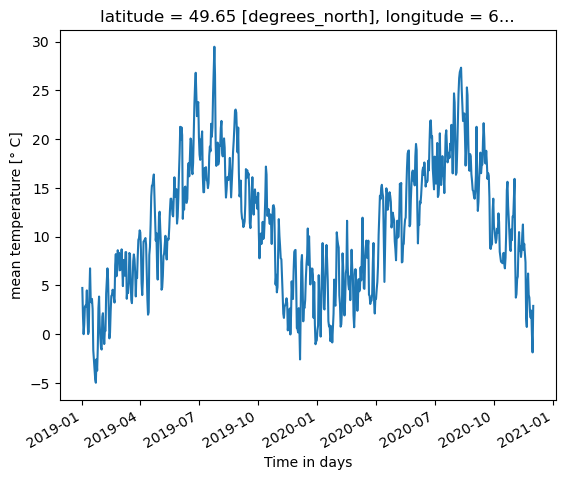

In [70]:

## Lux -location:
lat_city= lat  #### y
lon_city= lon   #### x
#https://ecmwf-projects.github.io/copernicus-training-c3s/reanalysis-climatology.html

print("list variables:")
print (list(ds.keys()))
print("list dims:")
print (list(ds.coords))
## Lux -location:
#lat_city=[49]
#lon_city=[6]
# Convert or name values:
TG = ds.tg
#copy attributes to get nice figure labels and change Kelvin to Celsius
TG.attrs = ds.tg.attrs
TG.attrs["units"] = '° C'
#isel is used to access point by index, ie:
lon_index = list(ds.longitude.values).index(ds.sel(longitude=lon_city, method='nearest').longitude)
lat_index = list(ds.latitude.values).index(ds.sel(latitude=lat_city, method='nearest').latitude)
#print (lat_index)
#print (lon_index)


#subest by lat-lon:
TG_location = TG.isel( longitude=lon_index,latitude=lat_index)
#subset by time:

Subset_time_and_loation= TG_location.sel(time=slice(Start_day, End_day))
print (".....")
#TG_location = TG.isel(X=6,Y=49)
Subset_time_and_loation.plot() 
print ("end")




Export results to database:

In [64]:
#export to csv-file:
filename = city_code + '.csv'
output_csv_file = result_path+"\\"+filename
print(output_csv_file)
Subset_time_and_loation.to_dataframe().to_csv(output_csv_file)
print ("done-next city:")


./../../../../s3/data/d003_climate/cl_02_e_obs/results/\LU001C1.csv
done-next city:
